# Exploratory Data Analysis voor project "Gezondheidszorg"

## Imports van de te gebruiken libraries

In [2]:
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from IPython.display import Image

## Ophalen van de data

De data kan op verschillende manieren worden opgehaald; we zullen drie manieren bekijken. Voor de API variant dient de rest server te zijn opgestart via het gekregen bash script. Tot op heden heb ik nog geen manier gevonden om dit in een notebook te doen. We gaan er voor deze optie dus vanuit dat de rest server opgestart is. Als dit niet zo is werkt het onderstaande blok code niet. 

### Data ophalen via rest API

In [3]:
'''
#url van API
url = "http://localhost:8080/medish_centrum_randstad/api/netlify?page=1"

#We slaan de response op 
response = requests.get(url).json()

#We slaan de response['data'] op als dataframe
df_api = pd.DataFrame(response['data'])

#We bekijken de descriptive statistics van de dataset
df_api.describe()
'''

'\n#url van API\nurl = "http://localhost:8080/medish_centrum_randstad/api/netlify?page=1"\n\n#We slaan de response op \nresponse = requests.get(url).json()\n\n#We slaan de response[\'data\'] op als dataframe\ndf_api = pd.DataFrame(response[\'data\'])\n\n#We bekijken de descriptive statistics van de dataset\ndf_api.describe()\n'

### Data ophalen met een SQLite query:

In [4]:
#We specificeren een pad en de table naam van de table die we willen opvragen
dbName = "../rest_server/medisch_centrum_randstad/data/db.sqlite3"
tableName = "rest_api_netlify"

#We maken een connectie
dbConnection = sqlite3.connect(dbName)

#We doen een query en maken hier een pandas dataframe van
df_db = pd.read_sql_query(f"SELECT * FROM {tableName}", dbConnection)

#We sluiten de connectie
dbConnection.close()

#Bekijken van descriptive statistics
df_db.describe()

,id,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar
count,4096.00000,4095.000000,4093.000000,4094.000000,4095.000000,4096.000000,4094.000000,4094.000000,4095.000000
mean,2048.50000,82.268352,183.880283,92.268442,2.402125,9.807446,2.264558,80.167416,6.482955
std,1182.55768,7.442579,12.623054,25.791314,1.170062,6.921461,1.800523,7.841687,2.710213
min,1.00000,63.900000,154.000000,50.000000,0.100000,0.000000,0.000000,57.000000,0.700000
25%,1024.75000,77.600000,175.000000,71.500000,1.500000,3.300000,0.600000,75.000000,4.400000
50%,2048.50000,81.800000,184.000000,89.500000,2.200000,9.500000,1.700000,79.700000,6.300000
75%,3072.25000,86.700000,193.000000,110.875000,3.200000,15.900000,4.000000,85.200000,8.400000
max,4096.00000,102.200000,214.000000,163.600000,5.500000,22.200000,6.000000,105.100000,13.800000


### Ophalen van data via .csv bestand / opmerking over versies van de dataset

Er gaan op het moment van schrijven meerdere versies van de data rond - hierdoor weet ik niet meer goed welke versie er nou uiteindelijk gebruikt moet worden. 

Als oplossing heb ik dus alle drie de varianten van het ophalen in het notebook staan. Hieronder zien we de laatste manier, namelijk het inlezen van een csv. 

Het onderstaande csv bestand is de "laatste" versie die we hebben gekregen, maar deze verschilt weer van de versies die we hierboven hebben opgehaald via SQL en de API.

In [5]:
#df_csv = pd.read_csv('data_new.csv')

#df_csv.describe()

In de csv versie van hierboven staan, in tegenstelling tot de SQL/API versies, vraagtekens en 'undefined' cellen. Ook hebben we een aantal kolommen van het type 'object'. Het idee is natuurlijk, los van welke dataset we uiteindelijk gebruiken, om het opschoonproces af te sluiten met een dataset zonder foutjes, lege cellen en andere onwenselijkheden.

In [6]:
#print(df_csv.dtypes)
#print('\n')
#print(df_api.dtypes)
#print('\n')
print(df_db.dtypes)

id            int64
genetic     float64
length      float64
mass        float64
exercise    float64
smoking     float64
alcohol     float64
lifespan    float64
sugar       float64
dtype: object


Voordat we iets doen met de data moeten we dus besluiten welke versie we gaan gebruiken. 

Omdat het ophalen via de SQLite query de voorkeur heeft gebruiken we deze versie van de data in het huidige notebook. Om op latere momenten nog te kunnen wisselen wordt hieronder wel beschreven hoe we alle drie de versies van de data schoon kunnen maken voor gebruik.

#### Opschonen van de csv data

Zoals we hebben kunnen zien in onze eerste blik op de datasets is het de bedoeling dat alle waardes van het type int/float moeten zijn. We kijken dus eerst of we dit eenvoudig kunnen doen:

De typecasting d.m.v. _df_csv.astype(float)_ werkt niet, dan krijgen we terug dat er o.a. een '?' wordt gevonden. We moeten dus zorgen dat we de data filteren op waardes die __niet__ kunnen worden omgezet naar floats.

De onderstaan code zou moeten werken voor elke versie van ons dataframe. We checken het hele dataframe op de mogelijkheid om waardes om te zetten naar floats. Kan dit niet (dus door een "?", "undefined" of ander afwijking), dan wordt de cel leeg gemaakt. Hierbij is het goed om te noteren dat dit natuurlijk alleen maar werkt als we inderdaad een dataframe hebben waarin we enkel numerieke waardes hebben staan. Deze oplossing werkt niet als we ook categorische variabelen hebben, maar dit is in deze dataset niet het geval.

In [7]:
'''
#In dit voorbeeld schonen we de csv versie van de data op:
for c in df_csv.columns:
    df_csv[c] = pd.to_numeric(df[c], errors='coerce')
'''

"\n#In dit voorbeeld schonen we de csv versie van de data op:\nfor c in df_csv.columns:\n    df_csv[c] = pd.to_numeric(df[c], errors='coerce')\n"

Nu bekijken we welke rijen er allemaal een NaN bevatten, die er dus in is gezet door onze bovenstaande functie:

In [8]:
#df_csv[df_csv.isna().any(axis=1)]

In [9]:
'''
#Nu kunnen we de rijen verwijderen:
df_csv = df_csv.dropna()

#Checken of er nog rijen terugkomen met lege cellen:
df_csv[df_csv.isna().any(axis=1)]
'''

'\n#Nu kunnen we de rijen verwijderen:\ndf_csv = df_csv.dropna()\n\n#Checken of er nog rijen terugkomen met lege cellen:\ndf_csv[df_csv.isna().any(axis=1)]\n'

In [10]:
#Als we de csv versie nu bekijken zien we dat alles is omgezet naar floats:
#df_csv.info()

We hebben nu gezien hoe we het csv bestand schoon krijgen. De rest van het huidige notebook werkt met de sql-opgehaalde data.

## Bekijken van data/eerste stappen in verkennen van de data

In [11]:
#De dataset die we gebruiken
df = df_db #eerder opgehaalde dataframe

df.describe()

,id,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar
count,4096.00000,4095.000000,4093.000000,4094.000000,4095.000000,4096.000000,4094.000000,4094.000000,4095.000000
mean,2048.50000,82.268352,183.880283,92.268442,2.402125,9.807446,2.264558,80.167416,6.482955
std,1182.55768,7.442579,12.623054,25.791314,1.170062,6.921461,1.800523,7.841687,2.710213
min,1.00000,63.900000,154.000000,50.000000,0.100000,0.000000,0.000000,57.000000,0.700000
25%,1024.75000,77.600000,175.000000,71.500000,1.500000,3.300000,0.600000,75.000000,4.400000
50%,2048.50000,81.800000,184.000000,89.500000,2.200000,9.500000,1.700000,79.700000,6.300000
75%,3072.25000,86.700000,193.000000,110.875000,3.200000,15.900000,4.000000,85.200000,8.400000
max,4096.00000,102.200000,214.000000,163.600000,5.500000,22.200000,6.000000,105.100000,13.800000


In deze eerste stappen bekijken we wat er in ons dataframe voorkomt qua waardes en type data:

Om te beginnen kijken we per variabel kort naar wat we hier over weten. In andere woorden: wat betekenen de waardes precies, en met welke eenheden werken we?

__id__: een variabel ter identificatie van elke rij

__genetic__: de genetische leeftijd in jaren (zonder invloed van levensstijl). Ook wel: de leeftijd die iemand zou "moeten" bereiken als levensstijl nul invloed zou hebben op de hoogte iemands levensverwachting. 

__length__: lengte in _centimeters_

__mass__: massa/gewicht in _kilogram_

__exercise__: hoeveelheid beweging in _uren per dag_

__smoking__: aantal _sigaretten per dag_

__alcohol__: aantal _glazen alcohol per dag_

__sugar__: hoeveelheid suiker in _klontjes per dag_ (volgens het voedingscentrum is één klontje ongeveer 4 gram suiker). 

__lifespan__: de uiteindelijke leeftijd die iemand heeft bereikt _met invloed van levensstijlfactoren_

In [12]:
#Voordat we verder kijken droppen we de id kolom:

df.drop(['id'], axis=1, inplace=True)

In [13]:
#Kijken of de data lege cellen bevat:

df.isna().sum()

genetic     1
length      3
mass        2
exercise    1
smoking     0
alcohol     2
lifespan    2
sugar       1
dtype: int64

In [14]:
#We bekijken alle rijen met een lege waarde:

df[df.isnull().any(axis=1)]

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar
889,88.1,156.0,112.9,0.7,19.5,0.9,NaN,3.0
947,82.0,193.0,68.0,1.3,17.2,NaN,75.3,1.2
1038,81.5,NaN,100.2,2.5,8.9,1.3,81.2,7.9
1861,76.7,NaN,115.9,1.1,4.8,3.1,74.4,2.9
2300,82.6,188.0,63.1,3.6,15.0,0.2,NaN,1.0
2354,74.8,183.0,123.2,2.3,13.8,NaN,70.4,8.1
2576,76.4,174.0,90.9,NaN,21.7,0.4,71.0,3.7
2721,88.9,179.0,NaN,3.1,0.2,0.5,91.5,5.1
2793,78.0,178.0,71.9,1.3,0.1,4.1,77.4,NaN
3043,66.7,NaN,74.0,2.4,0.1,2.0,67.6,10.5


In [15]:
#We verwijderen alle rijen met een NaN:
df.dropna(inplace=True)

#We hebben nu geen rijen meer met lege waardes
df[df.isnull().any(axis=1)]

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar


We kunnen nu wat descriptive statistics van ons dataframe ophalen. Dit is handig aangezien we zo vrij snel kunnen zien of er bijvoorbeeld vreemde uitersten in de data zitten:

In [16]:
df.describe()

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar
count,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000
mean,82.278624,183.885162,92.275930,2.403477,9.809035,2.266846,80.177693,6.487169
std,7.441333,12.622858,25.801031,1.170426,6.918614,1.801044,7.840508,2.708622
min,63.900000,154.000000,50.000000,0.100000,0.000000,0.000000,57.000000,0.700000
25%,77.600000,175.000000,71.475000,1.500000,3.375000,0.600000,75.000000,4.400000
50%,81.800000,184.000000,89.500000,2.200000,9.500000,1.700000,79.700000,6.300000
75%,86.700000,193.000000,110.825000,3.200000,15.900000,4.000000,85.200000,8.400000
max,102.200000,214.000000,163.600000,5.500000,22.200000,6.000000,105.100000,13.800000


## Spotten van afwijkende waardes/outliers

Om de data verder te verkennen maken we voor elke kolom een boxplot. Zo kunnen we een eerste inschatting maken van eventuele outliers, en zien we daarnaast ook hoe de waardes per kolom verdeeld zijn. 

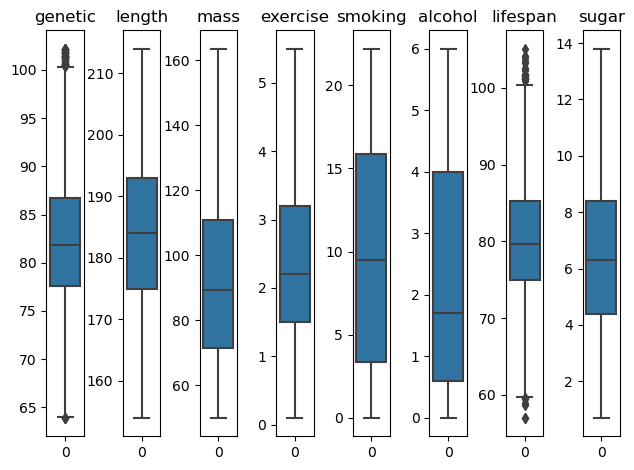

In [17]:
cols = [c for c in df.columns]

fig, axes = plt.subplots(ncols=len(cols))

for column, axis in zip(cols, axes):
        sns.boxplot(data=df[column], ax=axis) 
        axis.set_title(column)
        
plt.tight_layout(w_pad=0.2)
plt.show()

Hierboven zien we dat we alleen bij 'genetic' en 'lifespan' wat uitschieters hebben naar boven en beneden. De vraag is nu: zijn dit daadwerkelijk verkeerde datapunten, of zijn deze uitschieters "gewoon" onderdeel van de data. Er zijn immers mensen die een stuk jonger of ouder worden dan de meeste mensen. In dit geval is er besloten om deze uitschieters niet te verwijderen aangezien ze niet onwaarschijnlijk zijn, en het vrijwel zeker is dat dit echte datapunten zijn.

## Feature extraction/engineering

Nu we een redelijk schoon dataframe hebben zonder echte outliers, kunnen we kijken of we bepaalde features kunnen maken of bewerken. We beginnen met het aanmaken van een BMI kolom:

In [18]:
#We berekenen de bmi volgens de standaard formule:
df['BMI'] = df['mass'] / ((df['length'])/100)**2

#We kijken naar onze nieuwe variabel
df['BMI'].describe()

count    4084.000000
mean       27.682015
std         8.711661
min        11.320500
25%        20.938542
50%        26.476726
75%        33.207260
max        65.869494
Name: BMI, dtype: float64

Vervolgens kunnen we, volgens de categorieën van het voedingscentrum (https://www.voedingscentrum.nl/nl/bmi-meter), een grouping variabel maken voor BMI. 

In [19]:
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI cat'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,70], labels=labels)

We bekijken de aantallen voor de nieuw gemaakte kolom:

In [20]:
df['BMI cat'].value_counts()

Obese          1487
Normal         1151
Overweight      851
Underweight     595
Name: BMI cat, dtype: int64

In [21]:
df.describe()

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar,BMI
count,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000
mean,82.278624,183.885162,92.275930,2.403477,9.809035,2.266846,80.177693,6.487169,27.682015
std,7.441333,12.622858,25.801031,1.170426,6.918614,1.801044,7.840508,2.708622,8.711661
min,63.900000,154.000000,50.000000,0.100000,0.000000,0.000000,57.000000,0.700000,11.320500
25%,77.600000,175.000000,71.475000,1.500000,3.375000,0.600000,75.000000,4.400000,20.938542
50%,81.800000,184.000000,89.500000,2.200000,9.500000,1.700000,79.700000,6.300000,26.476726
75%,86.700000,193.000000,110.825000,3.200000,15.900000,4.000000,85.200000,8.400000,33.207260
max,102.200000,214.000000,163.600000,5.500000,22.200000,6.000000,105.100000,13.800000,65.869494


Aan de hand van een pairplot kunnen we een mooi overzicht krijgen van de verschillende variabelen en worden deze voor elke combinatie tegen elkaar geplot. Ook voegen we hier meteen de regressielijnen aan toe, en groeperen we aan de hand van de BMI categorieën.

In [22]:
sns.pairplot(df, kind='reg', corner=True, plot_kws={'line_kws':{'color':'black'}}, height = 3)
plt.figure(figsize=(10, 10))
plt.show()

<Figure size 1000x1000 with 0 Axes>

Een andere optie is het maken van een heatmap met correlaties tussen de variabelen. Hierbij is het goed om te vermelden dan de standaard methode Pearson correlatie is. 

<AxesSubplot: >

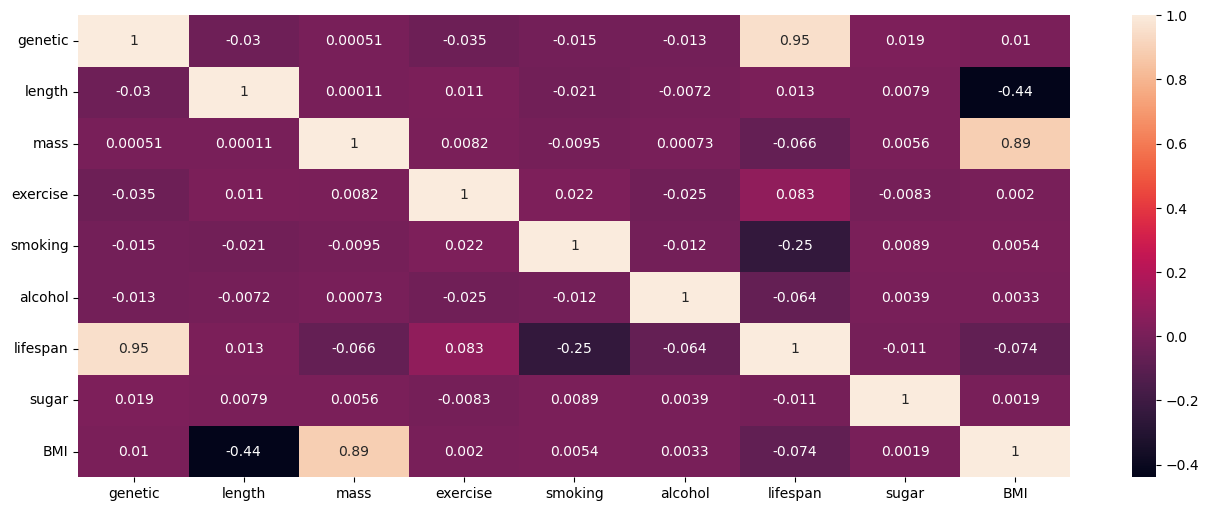

In [24]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Wat wordt er duidelijk uit de verkennende stappen die we tot nu toe hebben gezet? Voornamelijk dat genetische leeftijd een overduidelijke rol speelt bij de uiteindelijke levensduur van iemand. Roken speelt ook een kleine rol, maar verder lijken de levensstijlfactoren weinig te zeggen over iemands uiteindelijke leeftijd. 

### Genetische leeftijd en uiteindelijke levensduur

Tot op heden hebben we enkel gekeken naar de uiteindelijke levensduur en diens verhouding/afhankelijkheid tot de levensstijlvariabelen en genetische leeftijd. In andere woorden: onze interesse is voornamelijk uitgegaan naar de rol die de levensstijlvariabelen en genetische leeftijd spelen bij het __voorspellen van iemands uiteindelijke levensverwachting__.

Deze benadering is enigszins problematisch om de volgende redenen: we gaan er in deze situatie vanuit dat we de genetische leeftijd van een patient vooraf weten. Naast dat genetische leeftijd als concept moeilijk te operationaliseren is, kan het testen en vaststellen hiervan een praktisch struikelblok zijn voor patient en arts. Ook is de uiteindelijke levensduur zo sterk afhankelijk van genetische leeftijd (die dus lastig te verkrijgen is) dat we ons kunnen afvragen of de andere levensstijlvariabelen uberhaupt genoeg 'voorspellende kracht' hebben om iets wezenlijks toe te voegen aan de uiteindelijke voorspelling.

Een ander probleem met het voorspellen van een geschatte levensduur is dat de gebruiker van het model ontzettend voorzichtig dient te zijn (richting patient en naasten) met het toekennen van waarde aan deze voorspelling. We kunnen ons afvragen of het geven van absolute waardes/voorspellingen wenselijk is; niet elke patient zal een voorspelling van zijn/haar levensduur willen horen; een voorspelling die ook nog eens een grote mate van onzekerheid bevat.

### Een andere benadering 

Wat als we, voor de beschikbare datapunten, kijken naar het verschil tussen iemands genetische leeftijd en de leeftijd die ze uiteindelijk hebben bereikt? Zouden onze levensstijlvariabelen daar eventueel meer over kunnen zeggen dan over hoe oud iemand uiteindelijk zal worden?

Wat we in de volgende stappen doen is het maken van een apart dataframe, met daarin de levensstijlvariabelen en het verschil tussen de genetische leeftijd en uiteindelijke levensduur van de mensen uit de dataset.

Hierbij noteren we:

We berekenen hier het verschil tussen de lifespan en de genetisch leeftijd door de genetische leeftijd van de lifespan af te trekken. De waarde die hieruit voortkomt zegt dus iets over of iemand langer __(bij een positieve waarde)__ of __korter (bij een negatieve waarde)__ heeft geleefd dan de 'voorspelling' zou zijn op basis van haar/zijn genetisch materiaal. Dit verschil zouden we idealiter willen verklaren aan de hand van de beschikbare data over de levensstijl.

In [25]:
#We voegen een nieuwe kolom toe aan ons main dataframe 
df['age_diff'] = (df['lifespan'] - df['genetic'])

#We maken een apart dataframe voor deze data
df_diff = df[['exercise', 'smoking', 'alcohol', 'sugar', 'BMI', 'age_diff']]

Hieronder plotten we de variabelen exercise, smoking, sugar, alcohol en bmi tegen het verschil tussen de genetische en uiteindelijke leeftijd. Ter verduidelijking:

Als iemand korter heeft geleefd dan haar/zijn genetische leeftijd, hebben we een mogelijk negatief verband tussen de levensstijlvariabele en het verschil in levensduur. Naarmate de waarde van de levensstijlvariabele namelijk toeneemt, neemt de uiteindelijke leeftijd af ten opzichte van de genetische leeftijd.

In het geval dat iemand langer heeft geleefd dan haar/zijn genetische leeftijd, hebben we een mogelijk positief verband. Een toename in de levensstijlvariabele gaat in dat geval gepaard met een toename van de uiteindelijke leeftijd t.o.v. de genetische leeftijd. 

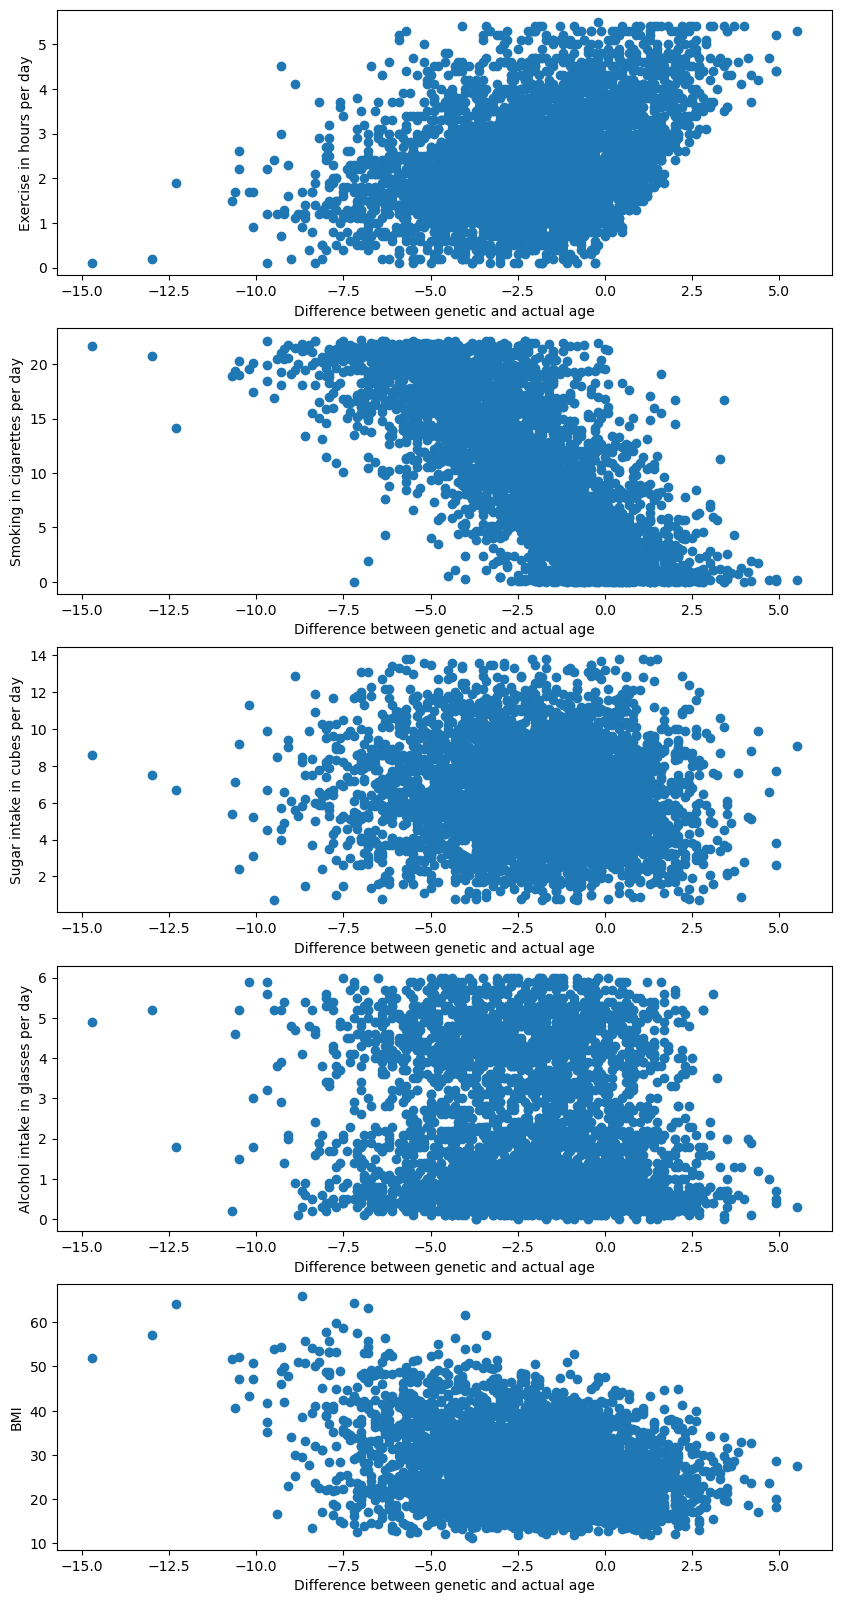

In [26]:
fig, ax = plt.subplots(5, figsize=(10,20))
ax[0].scatter(x = df_diff['age_diff'], y = df['exercise'])
ax[0].set_xlabel("Difference between genetic and actual age")
ax[0].set_ylabel("Exercise in hours per day")

ax[1].scatter(x = df_diff['age_diff'], y = df['smoking'])
ax[1].set_xlabel("Difference between genetic and actual age")
ax[1].set_ylabel("Smoking in cigarettes per day")

ax[2].scatter(x = df_diff['age_diff'], y = df['sugar'])
ax[2].set_xlabel("Difference between genetic and actual age")
ax[2].set_ylabel("Sugar intake in cubes per day")

ax[3].scatter(x = df_diff['age_diff'], y = df['alcohol'])
ax[3].set_xlabel("Difference between genetic and actual age")
ax[3].set_ylabel("Alcohol intake in glasses per day")

ax[4].scatter(x = df_diff['age_diff'], y = df['BMI'])
ax[4].set_xlabel("Difference between genetic and actual age")
ax[4].set_ylabel("BMI")

plt.show()


Ook voor het nieuwe dataframe maken we een heatmap met de onderlinge correlaties:

<AxesSubplot: >

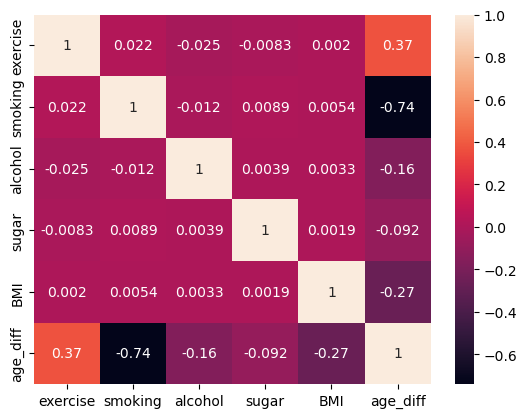

In [27]:
sns.heatmap(df_diff.corr(), annot=True)

Wat zouden we kunnen opmaken uit de bovenstaande visualisaties?

1. Roken heeft een overduidelijk negatief effect op het verschil tussen levensduur en genetische leeftijd. Met andere woorden: mensen leven, ten opzichte van hun genetische leeftijd, minder lang wanneer ze roken. 

2. Sporten heeft een redelijk positief effect op het verschil levensduur/genetische leeftijd. Naarmate iemand dus meer sport, neem de uiteindelijke levensduur toe ten opzichte van de genetische leeftijd.

3. BMI en alcohol lijken ook een bescheiden negatieve invloed te hebben op het verschil. Een hoger BMI en een hogere alcoholinname zorgen voor een afname van de uiteindelijke leeftijd t.o.v. de genetische leeftijd.

Wat volgt uit de bovenstaande observaties is, ten opzichte van het voorspellen van iemands uiteindelijke levensduur, een mogelijk realistischere manier om wat met de dataset te doen en eventueel advies te geven op basis van de observaties.

-Het is niet meer nodig om een genetische leeftijd van een patient te achterhalen

-In plaats van een absolute voorspelling van de uiteindelijke leeftijd, verkrijgen we een relatieve mate van 'invloed' van levensstijlkeuzes en de gevolgen hiervan voor iemands levensduur. Op basis hiervan kan een arts adviezen geven over levensstijlkeuzes. Ook kunnen arts en patient bijvoorbeeld samen de huidige levensstijlvariabelen van de patient invoeren, en de uitkomst vergelijken met een nieuwe set waardes waarin ze eventuele wenselijke veranderingen in levensstijl van de patient verwerken, om zo te kijken naar het verschil. Op deze manier is iemands uiteindelijke levensduur niet meer relevant, het gaat enkel om de winst die er te behalen valt door de levensstijlveranderingen, ongeacht de uiteindelijke levensduur.